In [2]:
library("DESeq2")
library("sva")
library(limma)
### Packages for plots
library("RColorBrewer")
library("amap")
library(ggplot2)
library("gplots")
#library(ggpubr)
library("pheatmap")
library(plotly)
library("dendextend")
options(warn=-1)

In [3]:
color = c('D10'='blue',
          'D20'='dodgerblue',
          'D40'='chartreuse',
          'D63'='cadetblue1',
          'D90'='palegoldenrod',
          'PHH'='red',
         'f-dHep'='darkslategray',
         'm-dHep'='chocolate4',
         'a-dHep'='deeppink')

In [4]:
# ## Modified plotPCA from DESeq2 package. 
# ## Shows the Names of the Samples (the first col of SampleTable), and uses ggrepel pkg to plot them conveniently.
# ## https://www.biostars.org/p/333436/
plotPCA.san <- function (object, intgroup = "Celltype", ntop = 5000, returnData = FALSE) 
{
  rv <- rowVars(assay(object))
  select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, 
                                                     length(rv)))]
  pca <- prcomp(t(assay(object)[select, ]))
  percentVar <- pca$sdev^2/sum(pca$sdev^2)
  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }
  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop = FALSE])
  group <- if (length(intgroup) > 1) {
    factor(apply(intgroup.df, 1, paste, collapse = " : "))
  }
  else {
    colData(object)[[intgroup]]
  }

  ## Select the PCAs and percentVar that you like instead of 1 and 2
  d <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], group = group, 
                  intgroup.df, name = colData(object)[,1])
  if (returnData) {
    attr(d, "percentVar") <- percentVar[1:2]
    return(d)
  }
    ggplot(data = d, aes_string(x = "PC1", y = "PC2", color = "group", label = "name")) +
           geom_point(size = 3) + 
           xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
           ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
           coord_fixed() + scale_colour_manual(values = color)
}

### Read in data

In [5]:
countData <- read.csv('../0_data/merged_counts.csv', header = TRUE, row.names=1, sep = ",",check.names=FALSE)
genes <- rownames(countData)
metaData <- read.table('../meta_sel_4pca.txt', header = TRUE, sep = "\t", check.names=FALSE)
rownames(metaData) <- metaData$Sample
metaData$Celltype <- factor(metaData$Celltype)
metaData$batch <- factor(metaData$batch)

countData <- as.data.frame(countData)[,metaData$Sample]
countData <- countData[!duplicated(row.names(countData)),]
dim(countData)
dim(metaData)

[1] 18304    19

[1] 19  3

#### Combat-seq

In [6]:
adjusted <- ComBat_seq(as.matrix(countData), batch=metaData$batch, group=NULL)
countData <- adjusted

Found 3 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


#### DESeq object

In [7]:
ddsFullCountTable <- DESeqDataSetFromMatrix(countData=countData, 
                                  colData=metaData, 
                                  design = ~Celltype, tidy = FALSE) 

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [ ]:
print(paste0("all genes, number:", dim(ddsFullCountTable)[1]))
ddsFullCountTable <- ddsFullCountTable[rowSums(counts(ddsFullCountTable)) > 200, ] 
print(paste0("exprs genes, number:", dim(ddsFullCountTable)[1]))

In [ ]:
### DESeq包的normalization方法，分三步：1）估计library size; 2)估计基因的dispersion; 3)GLM线性回归模型
dds <- DESeq(ddsFullCountTable, betaPrior=FALSE) # betaPrior=FALSE?
# save(dds, file="./HMC3_GSE155408/dds.RData")

In [10]:
dds_vst <- rlog(dds, blind=TRUE) ### rlog or vst
head(assay(dds_vst),1)

,mHep-3,mHep-H3,mHep-H6,PH-3,PH1-4,PH2-4,D63-1,D63-2,D63-3,iHepD21-4,iHp21-2,iHp21-3,D10-0,D10-1,D20-0,D20-1,D20-2,D40-1,D40-2
A1BG,10.00089,10.05755,10.03648,12.81912,12.48852,12.5036,11.77705,11.81633,11.98196,10.44435,9.803047,10.69135,9.816125,9.267707,11.54947,9.674779,11.94164,11.96803,10.18228


In [11]:
### limma removebatch
# assay(dds_vst) <- limma::removeBatchEffect(assay(dds_vst), dds_vst$batch)

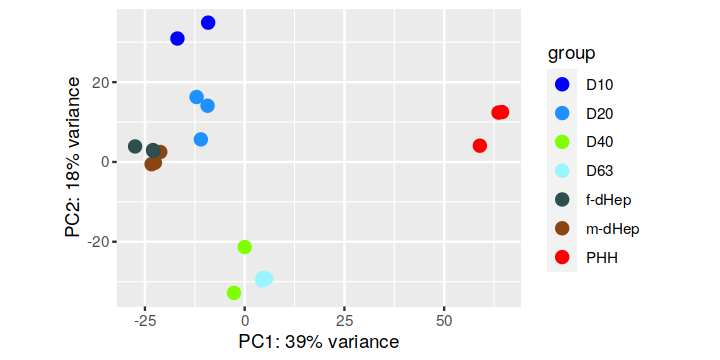

In [12]:
options(repr.plot.width=6, repr.plot.height=3)
p1 = plotPCA.san(dds_vst)
p1

# f,m,a,PHH data subset

In [15]:
data <- assay(dds_vst)
data <- data[,!colnames(data) %in% c(
                                     'D10-0','D10-1','D20-0','D20-1','D20-2','D40-1','D40-2')] #
metaData <- metaData[!rownames(metaData) %in% c(
                                                 'D10-0','D10-1','D20-0','D20-1','D20-2','D40-1','D40-2'),]

corrplot 0.92 loaded



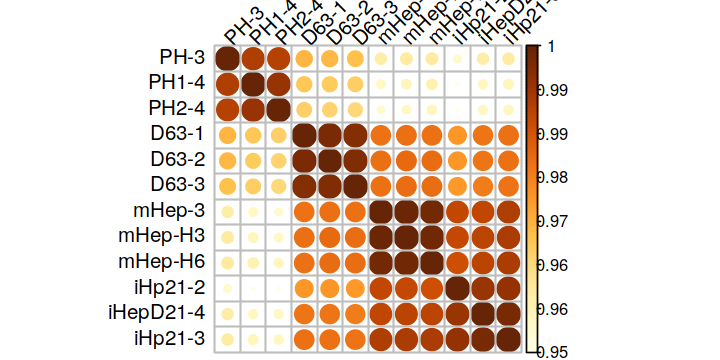

In [16]:
library("corrplot")
res <- cor(data)
ordered_samp <- c('PH-3','PH1-4','PH2-4',
                   'D63-1','D63-2','D63-3',
                   'mHep-3','mHep-H3','mHep-H6',
                    'iHp21-2','iHepD21-4','iHp21-3') 
#pdf(file="../Figures/fma_corr.20220810.pdf",width=6, height=6)
corrplot(res[ordered_samp, ordered_samp], 
         is.corr=FALSE,
         type = "full", order = "original",  #"original", "AOE", "FPC", "hclust", "alphabet"
         tl.col = "black", tl.srt = 45, tl.cex = 1,
        cl.length = 8)
#dev.off()

Z-score between sample for normalization

In [17]:
# zscore <- t(scale(t(data)))
# zscore <- zscore[complete.cases(zscore), ]

### Robust Z-score = 0.6745(x-median)/mad; Use robust Zscore to mitigate effect of outliers
median_ = apply(data,1, median)
mad_ = apply(data,1,mad)
zscore = 0.6745*(data - median_)[mad_>0.3,]/mad_[mad_>0.3]
zscore <- zscore[complete.cases(zscore), ]

In [18]:
print(dim(zscore), max(zscore), min(zscore))

[1] 3431   12


#### hclust

null device 
          1

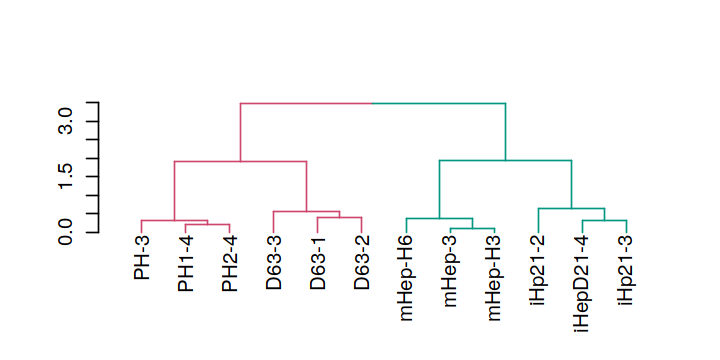

In [19]:
options(repr.plot.width=6, repr.plot.height=3)
dist_mat <- dist(cor(zscore), method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'complete')
avg_dend_obj <- as.dendrogram(hclust_avg)
avg_col_dend <- color_branches(avg_dend_obj, h = 3)
#pdf(file="../Figures/timecourse_hclust.20221123.pdf",height=3)
plot(avg_col_dend)
dev.off()

#### Heatmap

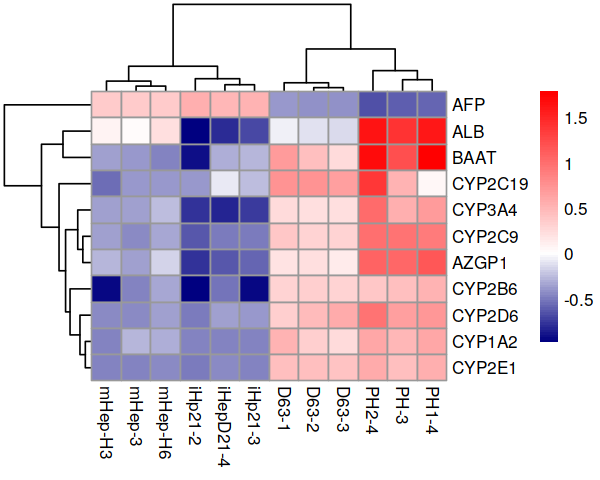

In [20]:
options(repr.plot.width=5, repr.plot.height=4)
fig <- pheatmap(zscore[c('ALB','CYP1A2','CYP2B6','CYP2C9','CYP2C19','CYP2D6','AFP','CYP3A4','CYP2E1','BAAT','AZGP1'),],
               color = colorRampPalette(colors = c("navyblue","white",'red'),bias=1.5)(100))

In [21]:
gene_subset1 <- read.csv('../Figures/sigup_Mtrans_C1_gene.csv')
gene_subset2 <- read.csv('../Figures/sigup_Mtrans_C023_gene.csv')
gene_subset3 <- read.csv('../Figures/heatmap_C1_sigdown.csv')
gene_subset4 <- read.csv('../Figures/heatmap_C2_sigdown.csv')

In [22]:
ordered_samps <- c('iHp21-2','iHepD21-4','iHp21-3',
                   'mHep-3','mHep-H3','mHep-H6',
                    'D63-1','D63-2','D63-3',
                    'PH-3','PH1-4','PH2-4') #

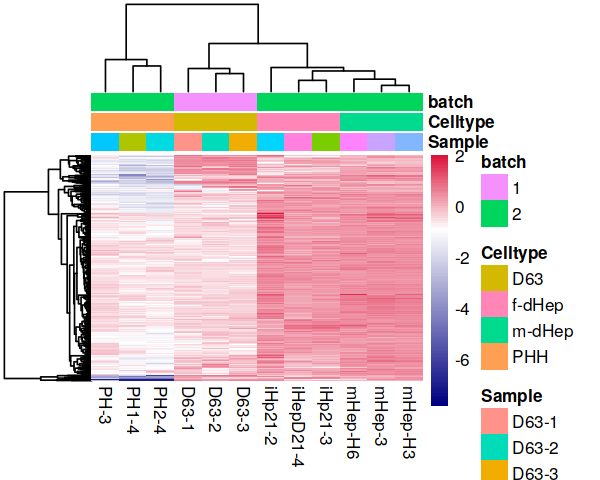

In [26]:
gene_subset <- c(gene_subset4$x)
zscore_ <- zscore[gene_subset[gene_subset %in% rownames(zscore)],]
hp2 = pheatmap(zscore_,
               cluster_row=TRUE, 
               cluster_col=TRUE,
               show_rownames=FALSE,
               annotation_col=metaData,
               color = colorRampPalette(c("navyblue", "white", "#DC143C"), bias=0.5)(100))
ordered_genes4 <- rownames(zscore_[hp2$tree_row[["order"]],])

In [27]:
# ordered_genes <- c(gene_subset1$X, gene_subset2$X, gene_subset3$X, gene_subset4$X)
ordered_genes <- c(ordered_genes1, ordered_genes2, ordered_genes3, ordered_genes4)

In [28]:
clusted_zscore = zscore[ordered_genes, ordered_samps]

In [29]:
clusted_zscore[clusted_zscore < (-2)] = -2
clusted_zscore[clusted_zscore > (2)] = 2

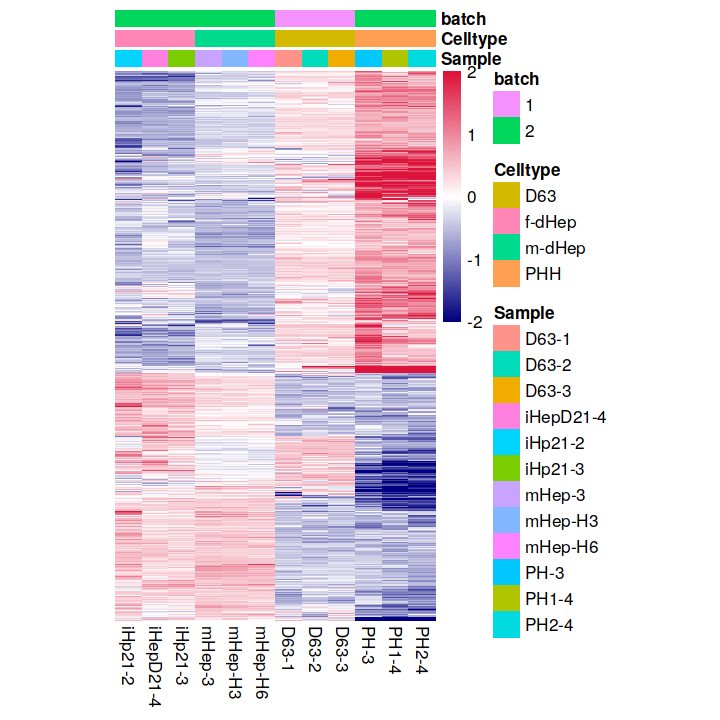

In [30]:
options(repr.plot.width=6, repr.plot.height=6)
hp3 = pheatmap(clusted_zscore,
               cluster_row=FALSE,
               cluster_col=FALSE,
               show_rownames=FALSE,
               annotation_col=metaData,
               border_color='lightgrey',
               cellwidth = 16,
              color = colorRampPalette(c("navyblue", "white", "#DC143C"), bias=1)(100))

In [31]:
# #ggsave(file="../Figures/timecourse_heatmap.20220804.svg", plot=hp3, width=6, height=6) #"heatmap.svg" or heatmap.png"
# pdf(file="../Figures/fma_heatmap.20221124.pdf",height=6)
# hp3
# dev.off()

# D10-D63 data subset

In [32]:
data2 <- assay(dds_vst) #normalized_counts,assay(dds_vst)

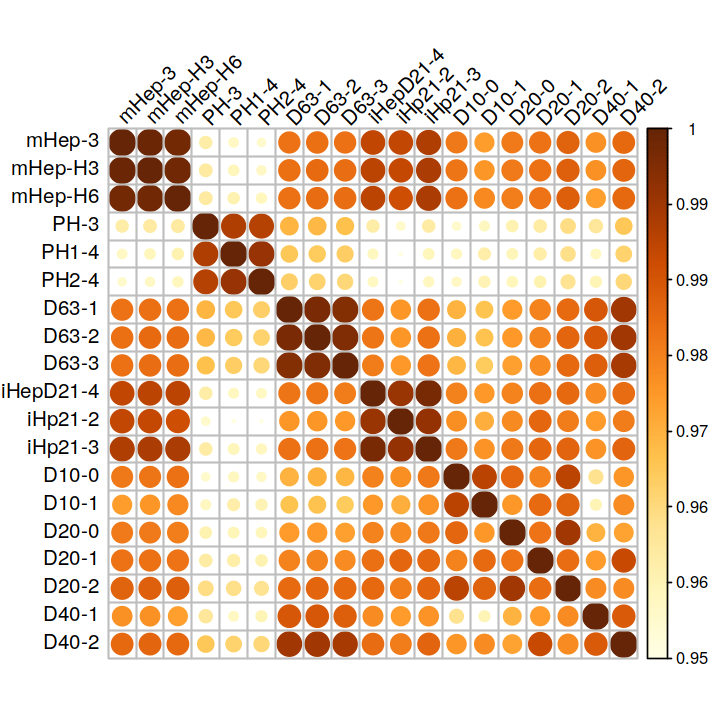

In [33]:
res <- cor(data2)
corrplot(res, 
         is.corr=FALSE,
         type = "full", order = "original",  #"original", "AOE", "FPC", "hclust", "alphabet"
         tl.col = "black", tl.srt = 45, tl.cex = 1,
        cl.length = 8)

In [37]:
# zscore <- t(scale(t(data2)))
# zscore <- zscore[complete.cases(zscore), ]

### Robust Z-score = 0.6745(x-median)/mad
median_ = apply(data2,1, median)
mad_ = apply(data2,1,mad)
zscore = 0.6745*(data2 - median_)[mad_>0.3,]/mad_[mad_>0.3]
zscore <- zscore[complete.cases(zscore), ]

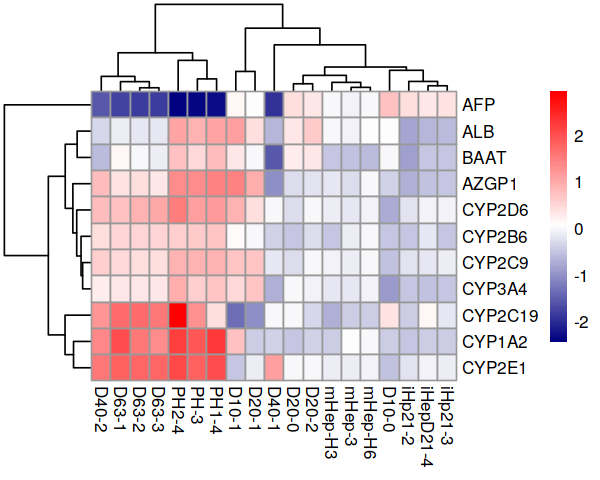

In [40]:
options(repr.plot.width=5, repr.plot.height=4)
fig <- pheatmap(zscore[c('ALB','CYP1A2','CYP2B6','CYP2C9','CYP2C19','CYP2D6','AFP','CYP3A4','CYP2E1','BAAT','AZGP1'),],
               color = colorRampPalette(colors = c("navyblue","white",'red'),bias=1.1)(100))

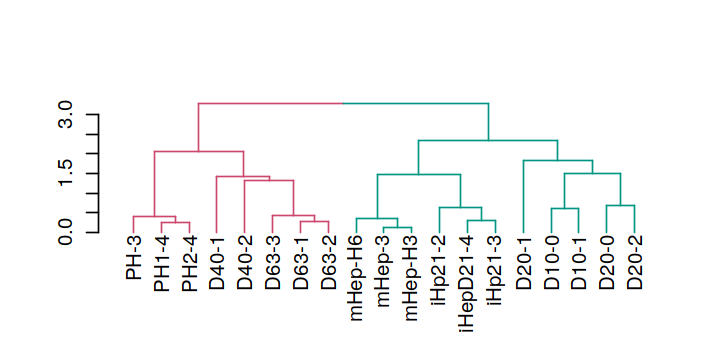

In [41]:
options(repr.plot.width=6, repr.plot.height=3)
dist_mat <- dist(cor(zscore), method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'complete')
avg_dend_obj <- as.dendrogram(hclust_avg)
avg_col_dend <- color_branches(avg_dend_obj, h = 3)
#pdf(file="../Figures/timecourse_hclust.20221123.pdf",height=3)
plot(avg_col_dend)
#dev.off()

In [42]:
#write.csv(zscore,'../2_Enrich_of_PHH_markers/timecourse_D10-60_zscore_by_COMBATseq.csv')

# DEGs

In [87]:
group_name <- "Celltype"
sampleA <- "PHH"
sampleB <- "m-dHep"

In [88]:
res <- results(dds, contrast=c(group_name, sampleA, sampleB))
res$ID <- rownames(res)
# DESeq2::plotMA(res, ylim=c(-8,8))

In [105]:
baseA <- assay(dds_vst)[, colData(dds)$Celltype == sampleA]
if (is.vector(baseA)){
    baseMeanA <- as.data.frame(baseA)
} else {
    baseMeanA <- as.data.frame(rowMeans(baseA))
}
colnames(baseMeanA) <- sampleA
head(baseMeanA,3)

baseB <- assay(dds_vst)[, colData(dds)$Celltype == sampleB]
if (is.vector(baseB)){
        baseMeanB <- as.data.frame(baseB)
} else {
        baseMeanB <- as.data.frame(rowMeans(baseB))
}
colnames(baseMeanB) <- sampleB
head(baseMeanB,3)

,PHH
,<dbl>
A1BG,12.60374
A1CF,13.63893
A2M,17.56789


,m-dHep
,<dbl>
A1BG,10.03164
A1CF,12.62244
A2M,16.15444


In [90]:
res <- cbind(baseMeanA, baseMeanB, as.data.frame(res))
head(res,2)

,PHH,m-dHep,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
A1BG,12.60374,10.03164,3373.808,3.699566,0.6168506,5.997508,2.003691e-09,3.283609e-08,A1BG
A1CF,13.63893,12.62244,8643.744,1.434867,0.2646524,5.421703,5.903406e-08,6.672490e-07,A1CF


In [93]:
res <- res[order(res$padj),]
DEG <- as.data.frame(res)

In [99]:
# write.csv(DEG, "../2_Enrich_of_PHH_markers/PHH_vs_mHep_DESeq2-fc.20221123.csv")

#### volcano plot;

In [94]:
DEG <- DEG[complete.cases(DEG[ , 'padj']),]

In [95]:
DEG$padj <- DEG$padj+1e-25
DEG$logP = -log10(DEG$padj)

In [313]:
# DEG$Group <- "" 
# sigDownGene <- DEG$ID[(DEG$log2FoldChange <= -0.3 & DEG$padj < 0.05)]
# sigUpGene <- DEG$ID[(DEG$log2FoldChange >= 1 & DEG$padj < 0.05)]
# sigGene <- c(sigDownGene,sigUpGene)
# DEG$Group[match(sigDownGene, DEG$ID)] <- 'Down'
# DEG$Group[match(sigUpGene, DEG$ID)] <- 'Up'

# DEG$GeneLab <- "" 
# DEG$GeneLab[match(label_genes, DEG$ID)] <- label_genes
# head(DEG)

# ggscatter(DEG,x="log2FoldChange",y="logP",color="Group",
#           label = DEG$GeneLab, 
#           font.label=18,
#      shape = 16,
#      xlab = "log2(Fold Change)",
#      ylab = "-log(pValue)",
#      #rug= T,
#      repel=F,
#      size = 1) + theme_test() ##label = DEG$GeneLab, font.label=7,

In [100]:
library(TCGAbiolinks)

In [103]:
label_genes <- c('ALB','CYP1A2','CYP2B6','CYP2C9','CYP2C19','CYP2D6','AFP','CYP3A4','CYP2E1','BAAT','AZGP1')

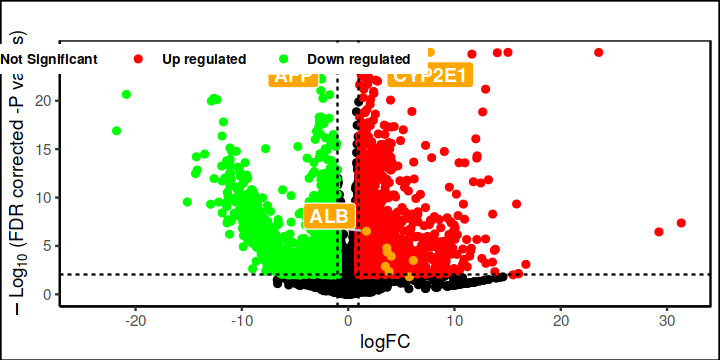

In [104]:
#volFig <- pdf("mvsPHH.vol.pdf",width=6, height=4)
TCGAVisualize_volcano(DEG$log2FoldChange, DEG$padj, title = "",
                      filename = volFig, 
                      xlab = "logFC",
                      names = DEG$ID, show.names = "highlighted",
                      x.cut = 1, y.cut = 0.01, 
                      highlight = c(label_genes),
                      highlight.color = c("orange")) +
                      theme(legend.title = element_blank(),
                            legend.text = element_text(size = 8, face = "bold"),
                            legend.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"),
                            legend.direction = "horizontal",
                            legend.position = c(0.2,0.93),
                            panel.background = element_rect(fill = "transparent",colour = "black"),
                            plot.background = element_rect(fill = "transparent",colour = "black"))
#dev.off()